In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("Company Stock and Investment.csv")
data.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 5 columns):
Date                       1984 non-null object
Oil Investments            1984 non-null float64
Gold Investments           1984 non-null float64
Comp Stock                 1984 non-null float64
Other sharesInvestments    1984 non-null float64
dtypes: float64(4), object(1)
memory usage: 77.6+ KB


In [4]:
data['Date']=pd.to_datetime(data['Date'],format='%d-%m-%Y')

# Gold Investments


In [5]:
#Lets consider the Gold Investments as our target and drop all others columns.

df=data.drop(columns=["Oil Investments","Comp Stock","Other sharesInvestments"],axis=1)
df.head()

,Date,Gold Investments
0,2009-12-31,0.000150
1,2010-01-04,0.001097
2,2010-01-05,0.001560
3,2010-01-06,0.006009
4,2010-01-07,0.000221


In [6]:
# making date as my index column

df.set_index('Date',inplace=True)
df.head()

,Gold Investments
Date,
2009-12-31,0.000150
2010-01-04,0.001097
2010-01-05,0.001560
2010-01-06,0.006009
2010-01-07,0.000221


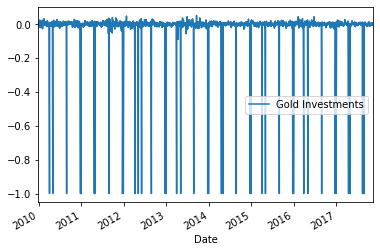

In [7]:
df.plot()

In [8]:
df.describe()

,Gold Investments
count,1984.000000
mean,-0.020152
std,0.140965
min,-1.000000
25%,-0.005881
50%,0.000000
75%,0.005454
max,0.049577


In [9]:
#check if data is stationarity or not

def adfuller_test(target):
    result=adfuller(target)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data  is stationary")
    else:
        print("weak evidence against null hypothesis, time series is non-stationary ")

In [10]:
adfuller_test(df['Gold Investments'])

ADF Test Statistic : -15.906853851669053
p-value : 8.208405770368892e-29
#Lags Used : 7
Number of Observations Used : 1976
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data  is stationary


In [11]:
# average the daily stock value of gold investment for each month

x = df['Gold Investments'].resample('MS').mean()
x['2009':]

Date
2009-12-01    0.000150
2010-01-01   -0.002469
2010-02-01    0.001521
2010-03-01    0.000317
2010-04-01   -0.045338
                ...   
2017-07-01    0.001025
2017-08-01   -0.086243
2017-09-01   -0.001084
2017-10-01   -0.000442
2017-11-01    0.000870
Freq: MS, Name: Gold Investments, Length: 96, dtype: float64

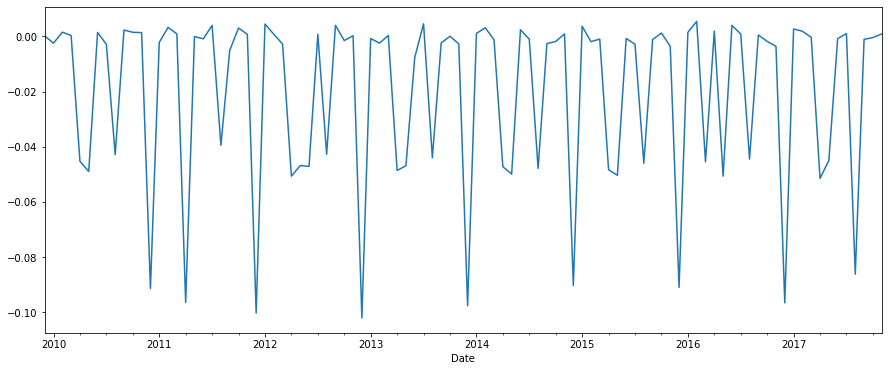

In [12]:
x.plot(figsize = (15, 6))

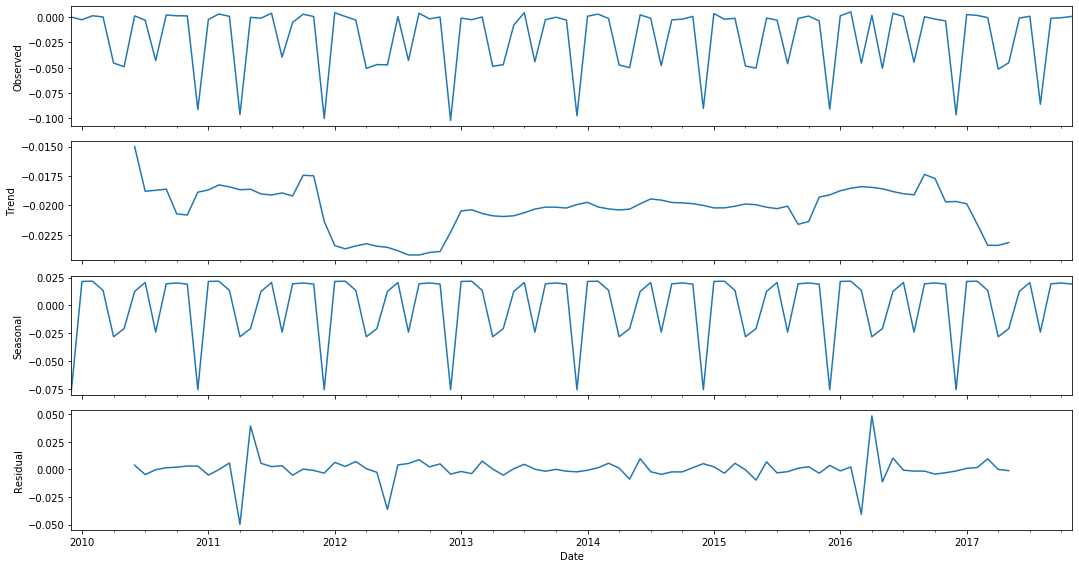

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

decomposition = sm.tsa.seasonal_decompose(x, model = 'additive')
fig = decomposition.plot()
plt.show()

Visualizing our data using a method called time-series decomposition that allows us to decompose our time series into distinct components: trend, seasonality, observed and residual

# Time series forecasting with ARIMA
Applying one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

In [14]:
# set the typical ranges for p, d, q
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
# Using Grid Search find the optimal set of parameters that yields the best performance
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param, seasonal_order = param_seasonal, enforce_stationary = False,enforce_invertibility=False) 
            result = mod.fit()   
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, result.aic))
        except:
            continue

In [16]:
model = sm.tsa.statespace.SARIMAX(x, order = (1, 1, 1),seasonal_order = (1, 1, 1, 12))
result = model.fit()
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3630      0.100     -3.616      0.000      -0.560      -0.166
ma.L1         -0.8798      0.105     -8.356      0.000      -1.086      -0.673
ar.S.L12      -0.7163      0.161     -4.436      0.000      -1.033      -0.400
ma.S.L12       0.1267      0.285      0.445      0.656      -0.431       0.685
sigma2         0.0003   3.69e-05      8.121      0.000       0.000       0.000


In [17]:
prediction = result.get_prediction(start = pd.to_datetime('2016-07-01'), dynamic = False)
prediction_ci = prediction.conf_int()
prediction_ci

,lower Gold Investments,upper Gold Investments
Date,,
2016-07-01,-0.034786,0.033077
2016-08-01,-0.079944,-0.012081
2016-09-01,-0.034257,0.033605
2016-10-01,-0.032814,0.035048
2016-11-01,-0.031802,0.036060
2016-12-01,-0.121262,-0.053400
2017-01-01,-0.028011,0.039852
2017-02-01,-0.032968,0.034895
2017-03-01,-0.053250,0.014613


# Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted stock value to real stock value of the time series, and we set forecasts to start at 2016–07–01 to the end of the data

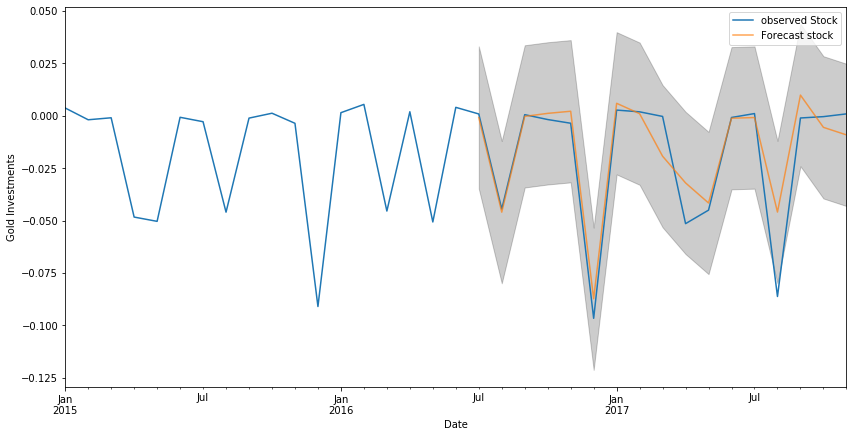

In [18]:
pred = result.get_prediction(start=pd.to_datetime('2016-07-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = x['2015':].plot(label='observed Stock')
pred.predicted_mean.plot(ax=ax, label='Forecast stock', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Gold Investments')
plt.legend()
plt.show()


# Making data for testing

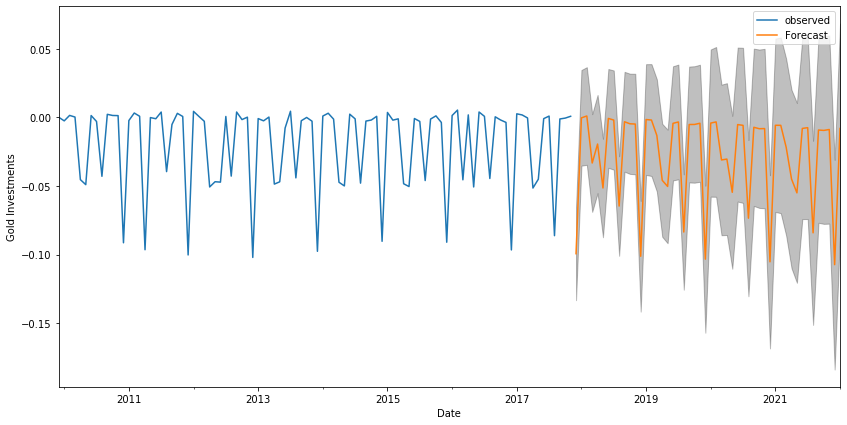

In [19]:
pred_uc = result.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = x.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Gold Investments')
plt.legend()
plt.show()

Our model clearly captured Gold Investment. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the intervals generated by our model, which show a up and down as we move further out into the future.